In [1]:
import sys
import numpy as np
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder.master("local[4]").getOrCreate()
compte=range(2011,2019)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/05 13:58:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
#test plus court:
compte=range(2011,2019)
n=8

#Données à récupérer
ev_racci=[]  #pourcentage des accidents sans morts
ev_rusag=[]  #pourcentage des usagers non inclus dans un accident mortel
agg=[]  #pourcentage des accidents en agglomération hors agglo, et NULL
lum=[]  #répartition des niveaux de luminosité
heu=[] #répartition des accidents sur 4 créneaux: 00-06h,06-12h,12-18h et 18-00h
depplus=[] #département ayant le plus d'accidents avec ce nombre précisé
atm=[] #météo lors des accidents
inter=[] #type d'intersection
col=[] #type de colision
catr=[] #répartition des catégories de route
circ=[] #répartition des sens de circulation
nbv=[] #répartition du nombre de voies
vosp=[] #présence ou non d'une voie réservée
prof=[] #répartition des profils de routes
plan=[] #tracé de la route
surf=[] #état de la route
infra=[] #aménagemment, infrastructure
catv=[] #catégorie de véhicules
obs=[] #répartition des obstacles fixes ET mobiles 
choc=[] #point de choc
manv=[] #manoeuvre effectuée lors de l'accident
place=[] #position de l'usager dans le véhicule
sexe=[] #sexe de l'usager
traj=[] #trajet lors de l'accident
secu=[] #présence et usage de l'équipement de sécurité

In [39]:
#Met 2h30 à se finir
for i in compte:
    #Année étudiée
    print(f"Année {i}")
    
    #On récupère en premier lieu les accident ne comportant aucun mort, on va devoir filtrer les usagers
    usag = spark.read.load(f"usagers_{i}.csv",format="csv",header=True)
    
    #Conversion du DataFrame en RDD pour utiliser filter
    rddu=usag.rdd
    
    #Regroupe les accidents comportant un mort, spécifiquement leur Num_Acc, numéro d'accident
    rddmort=rddu.filter(lambda x: x['grav']=='2') 
    lmort=rddmort.collect()
    L=[lmort[i][0] for i in range(len(lmort))]

    #On récupère les lieux , les végicules et les caractéristiques des accidents de l'année i 
    lieux=spark.read.load(f"lieux_{i}.csv",format="csv",header=True)
    vehic=spark.read.load(f"vehicules_{i}.csv",format="csv",header=True)
    carac=spark.read.load(f"caracteristiques_{i}.csv",format="csv",header=True)
    """
    lieux.show(n=5)
    vehic.show(n=5)
    carac.show(n=5)
    """

    #Conversion en rdd
    rddl=lieux.rdd
    rddv=vehic.rdd
    rddc=carac.rdd
    
    #On filtre ces nouveaux rdd en excluant les accidents mortels
    rddtu=rddu.filter(lambda x: x['Num_Acc'] not in L)
    rddtl=rddl.filter(lambda x: x['Num_Acc'] not in L)
    rddtv=rddv.filter(lambda x: x['Num_Acc'] not in L)
    rddtc=rddc.filter(lambda x: x['Num_Acc'] not in L)
    
    #On note quelques données
    nombr_usagers_tot=usag.count()
    nombr_acci_tot=carac.count()
    nombr_usagers_filt=rddtu.count()
    nombr_acci_filt=rddtc.count()
    nombr_vehic_tot=vehic.count()
    nombr_vehic_filt=rddtv.count()
    

    ratio_usag=nombr_usagers_filt/nombr_usagers_tot
    ratio_acci=nombr_acci_filt/nombr_acci_tot
    ev_racci.append(ratio_acci)
    ev_rusag.append(ratio_usag)
    #print(ratio_acci,ratio_usag)
    
    agglo=rddtc.filter(lambda x: x['agg']=='2').count()
    nonagglo=rddtc.filter(lambda x: x['agg']=='1').count()
    agg.append([agglo/nombr_acci_filt,nonagglo/nombr_acci_filt,1-nonagglo/nombr_acci_filt-agglo/nombr_acci_filt])
    #print(agg[0])
    
    lum1=rddtc.filter(lambda x: x['lum']=='1').count()/nombr_acci_filt
    lum2=rddtc.filter(lambda x: x['lum']=='2').count()/nombr_acci_filt
    lum3=rddtc.filter(lambda x: x['lum']=='3').count()/nombr_acci_filt
    lum4=rddtc.filter(lambda x: x['lum']=='4').count()/nombr_acci_filt
    lum5=rddtc.filter(lambda x: x['lum']=='5').count()/nombr_acci_filt
    lumnull=1-lum1-lum2-lum3-lum4-lum5
    lum.append([lum1,lum2,lum3,lum4,lum5,lumnull])
    #print(lum[0])
    
    
    heu1=rddtc.filter(lambda x: int(x['hrmn'])<=600).count()/nombr_acci_filt
    heu2=rddtc.filter(lambda x: int(x['hrmn'])<=1200 and int(x['hrmn'])>600).count()/nombr_acci_filt
    heu3=rddtc.filter(lambda x: int(x['hrmn'])<=1800 and int(x['hrmn'])>1200).count()/nombr_acci_filt
    heu4=rddtc.filter(lambda x: int(x['hrmn'])>1800).count()/nombr_acci_filt
    heunull=1-heu1-heu2-heu3-heu4
    heu.append([heu1,heu2,heu3,heu4,heunull])
    #print(heu[0])  
    
    dep=0
    nmax=0
    for i in range(1,96): #95 départements en france métropole
        if i in range(1,10): carac=str(i)+'00'
        else :carac=str(i)+'0'
        candidat=rddtc.filter(lambda x: x['dep']==carac).count()
        #print(candidat)
        if nmax<candidat: 
            nmax=candidat
            dep=i
    depplus.append([i,nmax])
    #print(i,nmax)

    
    atm1=rddtc.filter(lambda x: x['atm']=='1').count()/nombr_acci_filt
    atm2=rddtc.filter(lambda x: x['atm']=='2').count()/nombr_acci_filt
    atm3=rddtc.filter(lambda x: x['atm']=='3').count()/nombr_acci_filt
    atm4=rddtc.filter(lambda x: x['atm']=='4').count()/nombr_acci_filt
    atm5=rddtc.filter(lambda x: x['atm']=='5').count()/nombr_acci_filt
    atm6=rddtc.filter(lambda x: x['atm']=='6').count()/nombr_acci_filt
    atm7=rddtc.filter(lambda x: x['atm']=='7').count()/nombr_acci_filt
    atm8=rddtc.filter(lambda x: x['atm']=='8').count()/nombr_acci_filt
    atm9=rddtc.filter(lambda x: x['atm']=='9').count()/nombr_acci_filt
    atmnull=1-atm1-atm2-atm3-atm4-atm5-atm6-atm7-atm8-atm9
    atm.append([atm1,atm2,atm3,atm4,atm5,atm6,atm7,atm8,atm9,atmnull])
    #print(atm[0])
    
    
    int1=rddtc.filter(lambda x: x['int']=='1').count()/nombr_acci_filt
    int2=rddtc.filter(lambda x: x['int']=='2').count()/nombr_acci_filt
    int3=rddtc.filter(lambda x: x['int']=='3').count()/nombr_acci_filt
    int4=rddtc.filter(lambda x: x['int']=='4').count()/nombr_acci_filt
    int5=rddtc.filter(lambda x: x['int']=='5').count()/nombr_acci_filt
    int6=rddtc.filter(lambda x: x['int']=='6').count()/nombr_acci_filt
    int7=rddtc.filter(lambda x: x['int']=='7').count()/nombr_acci_filt
    int8=rddtc.filter(lambda x: x['int']=='8').count()/nombr_acci_filt
    int9=rddtc.filter(lambda x: x['int']=='9').count()/nombr_acci_filt
    intnull=1-int1-int2-int3-int4-int5-int6-int7-int8-int9
    inter.append([int1,int2,int3,int4,int5,int6,int7,int8,int9,intnull])
    #print(inter[0])
    
    
    
    col1=rddtc.filter(lambda x: x['col']=='1').count()/nombr_acci_filt
    col2=rddtc.filter(lambda x: x['col']=='2').count()/nombr_acci_filt
    col3=rddtc.filter(lambda x: x['col']=='3').count()/nombr_acci_filt
    col4=rddtc.filter(lambda x: x['col']=='4').count()/nombr_acci_filt
    col5=rddtc.filter(lambda x: x['col']=='5').count()/nombr_acci_filt
    col6=rddtc.filter(lambda x: x['col']=='6').count()/nombr_acci_filt
    col7=rddtc.filter(lambda x: x['col']=='7').count()/nombr_acci_filt
    colnull=1-col1-col2-col3-col4-col5-col6-col7
    col.append([col1,col2,col3,col4,col5,col6,col7,colnull])
    #print(col[0])
    
    catr1=rddtl.filter(lambda x: x['catr']=='1').count()/nombr_acci_filt
    catr2=rddtl.filter(lambda x: x['catr']=='2').count()/nombr_acci_filt
    catr3=rddtl.filter(lambda x: x['catr']=='3').count()/nombr_acci_filt
    catr4=rddtl.filter(lambda x: x['catr']=='4').count()/nombr_acci_filt
    catr5=rddtl.filter(lambda x: x['catr']=='5').count()/nombr_acci_filt
    catr6=rddtl.filter(lambda x: x['catr']=='6').count()/nombr_acci_filt
    catr9=rddtl.filter(lambda x: x['catr']=='9').count()/nombr_acci_filt
    catrnull=1-catr1-catr2-catr3-catr4-catr5-catr6-catr9
    catr.append([catr1,catr2,catr3,catr4,catr5,catr6,catr9,catrnull])    
    #print(catr[0])
    
    
    circ1=rddtl.filter(lambda x: x['circ']=='1').count()/nombr_acci_filt
    circ2=rddtl.filter(lambda x: x['circ']=='2').count()/nombr_acci_filt
    circ3=rddtl.filter(lambda x: x['circ']=='3').count()/nombr_acci_filt
    circ4=rddtl.filter(lambda x: x['circ']=='4').count()/nombr_acci_filt
    circnull=1-circ1-circ2-circ3-circ4
    circ.append([circ1,circ2,circ3,circ4,circnull])
    #print(circ[0])
    
    
    nbv1=rddtl.filter(lambda x: x['nbv']=='01').count()/nombr_acci_filt
    nbv2=rddtl.filter(lambda x: x['nbv']=='02').count()/nombr_acci_filt
    nbv3=rddtl.filter(lambda x: x['nbv']=='03').count()/nombr_acci_filt
    nbv4=rddtl.filter(lambda x: x['nbv']=='04').count()/nombr_acci_filt
    nbv5=rddtl.filter(lambda x: x['nbv']=='05').count()/nombr_acci_filt
    nbv6=rddtl.filter(lambda x: x['nbv']=='06').count()/nombr_acci_filt
    nbv7=rddtl.filter(lambda x: x['nbv']=='07').count()/nombr_acci_filt
    nbv8=rddtl.filter(lambda x: x['nbv']=='08').count()/nombr_acci_filt
    nbv9=rddtl.filter(lambda x: x['nbv']=='09').count()/nombr_acci_filt
    nbv10=rddtl.filter(lambda x: x['nbv']=='10').count()/nombr_acci_filt
    nbv11=rddtl.filter(lambda x: x['nbv']=='11').count()/nombr_acci_filt
    nbv12=rddtl.filter(lambda x: x['nbv']=='12').count()/nombr_acci_filt
    nbvnull=1-nbv1-nbv2-nbv3-nbv4-nbv5-nbv6-nbv7-nbv8-nbv9-nbv10-nbv11-nbv12
    nbv.append([nbv1,nbv2,nbv3,nbv4,nbv5,nbv6,nbv7,nbv8,nbv9,nbv10,nbv11,nbv12,nbvnull])
    #print(nbv[0])
    
    
    vosp0=rddtl.filter(lambda x: x['vosp']=='0').count()/nombr_acci_filt
    vosp1=rddtl.filter(lambda x: x['vosp']=='1').count()/nombr_acci_filt
    vosp2=rddtl.filter(lambda x: x['vosp']=='2').count()/nombr_acci_filt
    vosp3=rddtl.filter(lambda x: x['vosp']=='3').count()/nombr_acci_filt
    vospnull=1-vosp0-vosp1-vosp2-vosp3
    vosp.append([vosp0,vosp1,vosp2,vosp3,vospnull])
    #print(vosp[0])
    
    
    prof1=rddtl.filter(lambda x: x['prof']=='1').count()/nombr_acci_filt
    prof2=rddtl.filter(lambda x: x['prof']=='2').count()/nombr_acci_filt
    prof3=rddtl.filter(lambda x: x['prof']=='3').count()/nombr_acci_filt
    prof4=rddtl.filter(lambda x: x['prof']=='4').count()/nombr_acci_filt
    profnull=1-prof1-prof2-prof3-prof4
    prof.append([prof1,prof2,prof3,prof4,profnull])
    #print(prof[0])
    
    plan1=rddtl.filter(lambda x: x['plan']=='1').count()/nombr_acci_filt
    plan2=rddtl.filter(lambda x: x['plan']=='2').count()/nombr_acci_filt
    plan3=rddtl.filter(lambda x: x['plan']=='3').count()/nombr_acci_filt
    plan4=rddtl.filter(lambda x: x['plan']=='4').count()/nombr_acci_filt
    plannull=1-plan1-plan2-plan3-plan4
    plan.append([plan1,plan2,plan3,plan4,plannull])
    #print(plan[0])   
    
  
    surf1=rddtl.filter(lambda x: x['surf']=='1').count()/nombr_acci_filt
    surf2=rddtl.filter(lambda x: x['surf']=='2').count()/nombr_acci_filt
    surf3=rddtl.filter(lambda x: x['surf']=='3').count()/nombr_acci_filt
    surf4=rddtl.filter(lambda x: x['surf']=='4').count()/nombr_acci_filt
    surf5=rddtl.filter(lambda x: x['surf']=='5').count()/nombr_acci_filt
    surf6=rddtl.filter(lambda x: x['surf']=='6').count()/nombr_acci_filt
    surf7=rddtl.filter(lambda x: x['surf']=='7').count()/nombr_acci_filt
    surf8=rddtl.filter(lambda x: x['surf']=='8').count()/nombr_acci_filt
    surf9=rddtl.filter(lambda x: x['surf']=='9').count()/nombr_acci_filt
    surfnull=1-surf1-surf2-surf3-surf4-surf5-surf6-surf7-surf8-surf9
    surf.append([surf1,surf2,surf3,surf4,surf5,surf6,surf7,surf8,surf9,surfnull])    
    #print(surf[0])
    
    
    infr0=rddtl.filter(lambda x: x['infra']=='0').count()/nombr_acci_filt
    infr1=rddtl.filter(lambda x: x['infra']=='1').count()/nombr_acci_filt
    infr2=rddtl.filter(lambda x: x['infra']=='2').count()/nombr_acci_filt
    infr3=rddtl.filter(lambda x: x['infra']=='3').count()/nombr_acci_filt
    infr4=rddtl.filter(lambda x: x['infra']=='4').count()/nombr_acci_filt
    infr5=rddtl.filter(lambda x: x['infra']=='5').count()/nombr_acci_filt
    infr6=rddtl.filter(lambda x: x['infra']=='6').count()/nombr_acci_filt
    infr7=rddtl.filter(lambda x: x['infra']=='7').count()/nombr_acci_filt
    infrnull=1-infr0-infr1-infr2-infr3-infr4-infr5-infr6-infr7
    infra.append([infr0,infr1,infr2,infr3,infr4,infr5,infr6,infr7,infrnull])    
    #print(infra[0])


    catv1=rddtv.filter(lambda x: x['catv']=='01').count()/nombr_vehic_filt
    catv2=rddtv.filter(lambda x: x['catv']=='02').count()/nombr_vehic_filt
    catv3=rddtv.filter(lambda x: x['catv']=='03').count()/nombr_vehic_filt
    catv4=rddtv.filter(lambda x: x['catv']=='04').count()/nombr_vehic_filt
    catv5=rddtv.filter(lambda x: x['catv']=='05').count()/nombr_vehic_filt
    catv6=rddtv.filter(lambda x: x['catv']=='06').count()/nombr_vehic_filt
    catv7=rddtv.filter(lambda x: x['catv']=='07').count()/nombr_vehic_filt
    catv8=rddtv.filter(lambda x: x['catv']=='08').count()/nombr_vehic_filt
    catv9=rddtv.filter(lambda x: x['catv']=='09').count()/nombr_vehic_filt
    catv10=rddtv.filter(lambda x: x['catv']=='10').count()/nombr_vehic_filt
    catv11=rddtv.filter(lambda x: x['catv']=='11').count()/nombr_vehic_filt
    catv12=rddtv.filter(lambda x: x['catv']=='12').count()/nombr_vehic_filt
    catv13=rddtv.filter(lambda x: x['catv']=='13').count()/nombr_vehic_filt
    catv14=rddtv.filter(lambda x: x['catv']=='14').count()/nombr_vehic_filt
    catv15=rddtv.filter(lambda x: x['catv']=='15').count()/nombr_vehic_filt
    catv16=rddtv.filter(lambda x: x['catv']=='16').count()/nombr_vehic_filt
    catv17=rddtv.filter(lambda x: x['catv']=='17').count()/nombr_vehic_filt
    catv18=rddtv.filter(lambda x: x['catv']=='18').count()/nombr_vehic_filt
    catv19=rddtv.filter(lambda x: x['catv']=='19').count()/nombr_vehic_filt
    catv20=rddtv.filter(lambda x: x['catv']=='20').count()/nombr_vehic_filt
    catv21=rddtv.filter(lambda x: x['catv']=='21').count()/nombr_vehic_filt
    catv22=rddtv.filter(lambda x: x['catv']=='22').count()/nombr_vehic_filt
    catv23=rddtv.filter(lambda x: x['catv']=='23').count()/nombr_vehic_filt
    catv24=rddtv.filter(lambda x: x['catv']=='24').count()/nombr_vehic_filt
    catv25=rddtv.filter(lambda x: x['catv']=='25').count()/nombr_vehic_filt
    catv26=rddtv.filter(lambda x: x['catv']=='26').count()/nombr_vehic_filt
    catv27=rddtv.filter(lambda x: x['catv']=='27').count()/nombr_vehic_filt
    catv28=rddtv.filter(lambda x: x['catv']=='28').count()/nombr_vehic_filt
    catv29=rddtv.filter(lambda x: x['catv']=='29').count()/nombr_vehic_filt
    catv30=rddtv.filter(lambda x: x['catv']=='30').count()/nombr_vehic_filt
    catv31=rddtv.filter(lambda x: x['catv']=='31').count()/nombr_vehic_filt
    catv32=rddtv.filter(lambda x: x['catv']=='32').count()/nombr_vehic_filt
    catv33=rddtv.filter(lambda x: x['catv']=='33').count()/nombr_vehic_filt
    catv34=rddtv.filter(lambda x: x['catv']=='34').count()/nombr_vehic_filt
    catv35=rddtv.filter(lambda x: x['catv']=='35').count()/nombr_vehic_filt
    catv36=rddtv.filter(lambda x: x['catv']=='36').count()/nombr_vehic_filt
    catv37=rddtv.filter(lambda x: x['catv']=='37').count()/nombr_vehic_filt
    catv38=rddtv.filter(lambda x: x['catv']=='38').count()/nombr_vehic_filt
    catv39=rddtv.filter(lambda x: x['catv']=='39').count()/nombr_vehic_filt
    catv40=rddtv.filter(lambda x: x['catv']=='40').count()/nombr_vehic_filt
    catv99=rddtv.filter(lambda x: x['catv']=='99').count()/nombr_vehic_filt
    catvnull=1-catv1-catv2-catv3-catv4-catv5-catv6-catv7-catv8-catv9-catv10-catv11-catv12-catv13-catv14-catv15-catv16-catv17-catv18-catv19-catv20-catv21-catv22-catv23-catv24-catv25-catv26-catv27-catv28-catv29-catv30-catv31-catv32-catv33-catv34-catv35-catv36-catv37-catv38-catv39-catv40-catv99
    catv.append([catv1,catv2,catv3,catv4,catv5,catv6,catv7,catv8,catv9,catv10,catv11,catv12,catv13,catv14,catv15,catv16,catv17,catv18,catv19,catv20,catv21,catv22,catv23,catv24,catv25,catv26,catv27,catv28,catv29,catv30,catv31,catv32,catv33,catv34,catv35,catv36,catv37,catv38,catv39,catv40,catv99,catvnull])    
    #print(catv[0]) 
    
    obs1=rddtv.filter(lambda x: x['obs']=='01').count()/nombr_vehic_filt
    obs2=rddtv.filter(lambda x: x['obs']=='02').count()/nombr_vehic_filt
    obs3=rddtv.filter(lambda x: x['obs']=='03').count()/nombr_vehic_filt
    obs4=rddtv.filter(lambda x: x['obs']=='04').count()/nombr_vehic_filt
    obs5=rddtv.filter(lambda x: x['obs']=='05').count()/nombr_vehic_filt
    obs6=rddtv.filter(lambda x: x['obs']=='06').count()/nombr_vehic_filt
    obs7=rddtv.filter(lambda x: x['obs']=='07').count()/nombr_vehic_filt
    obs8=rddtv.filter(lambda x: x['obs']=='08').count()/nombr_vehic_filt
    obs9=rddtv.filter(lambda x: x['obs']=='09').count()/nombr_vehic_filt
    obs10=rddtv.filter(lambda x: x['obs']=='10').count()/nombr_vehic_filt
    obs11=rddtv.filter(lambda x: x['obs']=='11').count()/nombr_vehic_filt
    obs12=rddtv.filter(lambda x: x['obs']=='12').count()/nombr_vehic_filt
    obs13=rddtv.filter(lambda x: x['obs']=='13').count()/nombr_vehic_filt
    obs14=rddtv.filter(lambda x: x['obs']=='14').count()/nombr_vehic_filt
    obs15=rddtv.filter(lambda x: x['obs']=='15').count()/nombr_vehic_filt
    obs16=rddtv.filter(lambda x: x['obs']=='16').count()/nombr_vehic_filt
    obs17=rddtv.filter(lambda x: x['obsm']=='1').count()/nombr_vehic_filt
    obs18=rddtv.filter(lambda x: x['obsm']=='2').count()/nombr_vehic_filt
    obs19=rddtv.filter(lambda x: x['obsm']=='3').count()/nombr_vehic_filt
    obs20=rddtv.filter(lambda x: x['obsm']=='4').count()/nombr_vehic_filt
    obs21=rddtv.filter(lambda x: x['obsm']=='5').count()/nombr_vehic_filt
    obs22=rddtv.filter(lambda x: x['obsm']=='6').count()/nombr_vehic_filt
    obs23=rddtv.filter(lambda x: x['obsm']=='7').count()/nombr_vehic_filt #Inutile
    obs24=rddtv.filter(lambda x: x['obsm']=='8').count()/nombr_vehic_filt #Inutile
    obs25=rddtv.filter(lambda x: x['obsm']=='9').count()/nombr_vehic_filt
    obsnull=1-obs1-obs2-obs3-obs4-obs5-obs6-obs7-obs8-obs9-obs10-obs11-obs12-obs13-obs14-obs15-obs16-obs17-obs18-obs19-obs20-obs21-obs22-obs23-obs24-obs25
    obs.append([obs1,obs2,obs3,obs4,obs5,obs6,obs7,obs8,obs9,obs10,obs11,obs12,obs13,obs14,obs15,obs16,obs17,obs18,obs19,obs20,obs21,obs22,obs23,obs24,obs25,obsnull])
    #print(obs[0])
    
    
    choc1=rddtv.filter(lambda x: x['choc']=='1').count()/nombr_vehic_filt
    choc2=rddtv.filter(lambda x: x['choc']=='2').count()/nombr_vehic_filt
    choc3=rddtv.filter(lambda x: x['choc']=='3').count()/nombr_vehic_filt
    choc4=rddtv.filter(lambda x: x['choc']=='4').count()/nombr_vehic_filt
    choc5=rddtv.filter(lambda x: x['choc']=='5').count()/nombr_vehic_filt
    choc6=rddtv.filter(lambda x: x['choc']=='6').count()/nombr_vehic_filt
    choc7=rddtv.filter(lambda x: x['choc']=='7').count()/nombr_vehic_filt
    choc8=rddtv.filter(lambda x: x['choc']=='8').count()/nombr_vehic_filt
    choc9=rddtv.filter(lambda x: x['choc']=='9').count()/nombr_vehic_filt    
    chocnull=1-choc1-choc2-choc3-choc4-choc5-choc6-choc7-choc8-choc9
    choc.append([choc1,choc2,choc3,choc4,choc5,choc6,choc7,choc8,choc9,chocnull])
    #print(choc[0])
 
    
    manv1=rddtv.filter(lambda x: x['manv']=='01').count()/nombr_vehic_filt
    manv2=rddtv.filter(lambda x: x['manv']=='02').count()/nombr_vehic_filt
    manv3=rddtv.filter(lambda x: x['manv']=='03').count()/nombr_vehic_filt
    manv4=rddtv.filter(lambda x: x['manv']=='04').count()/nombr_vehic_filt
    manv5=rddtv.filter(lambda x: x['manv']=='05').count()/nombr_vehic_filt
    manv6=rddtv.filter(lambda x: x['manv']=='06').count()/nombr_vehic_filt
    manv7=rddtv.filter(lambda x: x['manv']=='07').count()/nombr_vehic_filt
    manv8=rddtv.filter(lambda x: x['manv']=='08').count()/nombr_vehic_filt
    manv9=rddtv.filter(lambda x: x['manv']=='09').count()/nombr_vehic_filt
    manv10=rddtv.filter(lambda x: x['manv']=='10').count()/nombr_vehic_filt
    manv11=rddtv.filter(lambda x: x['manv']=='11').count()/nombr_vehic_filt
    manv12=rddtv.filter(lambda x: x['manv']=='12').count()/nombr_vehic_filt
    manv13=rddtv.filter(lambda x: x['manv']=='13').count()/nombr_vehic_filt
    manv14=rddtv.filter(lambda x: x['manv']=='14').count()/nombr_vehic_filt
    manv15=rddtv.filter(lambda x: x['manv']=='15').count()/nombr_vehic_filt
    manv16=rddtv.filter(lambda x: x['manv']=='16').count()/nombr_vehic_filt
    manv17=rddtv.filter(lambda x: x['manv']=='17').count()/nombr_vehic_filt
    manv18=rddtv.filter(lambda x: x['manv']=='18').count()/nombr_vehic_filt
    manv19=rddtv.filter(lambda x: x['manv']=='19').count()/nombr_vehic_filt
    manv20=rddtv.filter(lambda x: x['manv']=='20').count()/nombr_vehic_filt
    manv21=rddtv.filter(lambda x: x['manv']=='21').count()/nombr_vehic_filt
    manv22=rddtv.filter(lambda x: x['manv']=='22').count()/nombr_vehic_filt
    manv23=rddtv.filter(lambda x: x['manv']=='23').count()/nombr_vehic_filt
    manv24=rddtv.filter(lambda x: x['manv']=='24').count()/nombr_vehic_filt
    manvnull=1-manv1-manv2-manv3-manv4-manv5-manv6-manv7-manv8-manv9-manv10-manv11-manv12-manv13-manv14-manv15-manv16-manv17-manv18-manv19-manv20-manv21-manv22-manv23-manv24
    manv.append([manv1,manv2,manv3,manv4,manv5,manv6,manv7,manv8,manv9,manv10,manv11,manv12,manv13,manv14,manv15,manv16,manv17,manv18,manv19,manv20,manv21,manv22,manv23,manv24,manvnull])
    #print(manv[0])
    

    place1=rddtu.filter(lambda x: x['place']=='1').count()/nombr_usagers_filt
    place2=rddtu.filter(lambda x: x['place']=='2').count()/nombr_usagers_filt
    place3=rddtu.filter(lambda x: x['place']=='3').count()/nombr_usagers_filt
    place4=rddtu.filter(lambda x: x['place']=='4').count()/nombr_usagers_filt
    place5=rddtu.filter(lambda x: x['place']=='5').count()/nombr_usagers_filt
    place6=rddtu.filter(lambda x: x['place']=='6').count()/nombr_usagers_filt
    place7=rddtu.filter(lambda x: x['place']=='7').count()/nombr_usagers_filt
    place8=rddtu.filter(lambda x: x['place']=='8').count()/nombr_usagers_filt
    place9=rddtu.filter(lambda x: x['place']=='9').count()/nombr_usagers_filt  
    placenull=1-place1-place2-place3-place4-place5-place6-place7-place8-place9
    place.append([place1,place2,place3,place4,place5,place6,place7,place8,place9,placenull])
    #print(place[0])
    
    sexe1=rddtu.filter(lambda x: x['sexe']=='1').count()/nombr_usagers_filt
    sexe2=rddtu.filter(lambda x: x['sexe']=='2').count()/nombr_usagers_filt
    sexe.append([sexe1,sexe2])
    #print(sexe[0])
    
    traj1=rddtu.filter(lambda x: x['trajet']=='1').count()/nombr_usagers_filt
    traj2=rddtu.filter(lambda x: x['trajet']=='2').count()/nombr_usagers_filt
    traj3=rddtu.filter(lambda x: x['trajet']=='3').count()/nombr_usagers_filt
    traj4=rddtu.filter(lambda x: x['trajet']=='4').count()/nombr_usagers_filt
    traj5=rddtu.filter(lambda x: x['trajet']=='5').count()/nombr_usagers_filt
    traj9=rddtu.filter(lambda x: x['trajet']=='9').count()/nombr_usagers_filt  
    trajnull=1-traj1-traj2-traj3-traj4-traj5-traj9
    traj.append([traj1,traj2,traj3,traj4,traj5,traj9,trajnull])
    #print(traj[0])
    
    
    secu11=rddtu.filter(lambda x: x['secu']=='11').count()/nombr_usagers_filt
    secu12=rddtu.filter(lambda x: x['secu']=='12').count()/nombr_usagers_filt
    secu13=rddtu.filter(lambda x: x['secu']=='13').count()/nombr_usagers_filt
    secu21=rddtu.filter(lambda x: x['secu']=='21').count()/nombr_usagers_filt
    secu22=rddtu.filter(lambda x: x['secu']=='22').count()/nombr_usagers_filt
    secu23=rddtu.filter(lambda x: x['secu']=='23').count()/nombr_usagers_filt
    secu31=rddtu.filter(lambda x: x['secu']=='31').count()/nombr_usagers_filt
    secu32=rddtu.filter(lambda x: x['secu']=='32').count()/nombr_usagers_filt
    secu33=rddtu.filter(lambda x: x['secu']=='33').count()/nombr_usagers_filt
    secu41=rddtu.filter(lambda x: x['secu']=='41').count()/nombr_usagers_filt
    secu42=rddtu.filter(lambda x: x['secu']=='42').count()/nombr_usagers_filt
    secu43=rddtu.filter(lambda x: x['secu']=='43').count()/nombr_usagers_filt
    secu91=rddtu.filter(lambda x: x['secu']=='91').count()/nombr_usagers_filt
    secu92=rddtu.filter(lambda x: x['secu']=='92').count()/nombr_usagers_filt
    secu93=rddtu.filter(lambda x: x['secu']=='93').count()/nombr_usagers_filt
    secunull=1-secu11-secu12-secu13-secu21-secu22-secu23-secu31-secu32-secu33-secu41-secu42-secu43-secu91-secu92-secu93
    secu.append([secu11,secu12,secu13,secu21,secu22,secu23,secu31,secu32,secu33,secu41,secu42,secu43,secu91,secu92,secu93,secunull])
    #print(secu[0])
 
    #print(rddtu.collect()[0])  #pour visualiser les colonnes et sorties, remplacer rddt* par u,v,l ou c
    

Année 2011


Année 2012


Année 2013


Année 2014


Année 2015


Année 2016


Année 2017


Année 2018


In [5]:
n=8 #nombre d'années étudiées

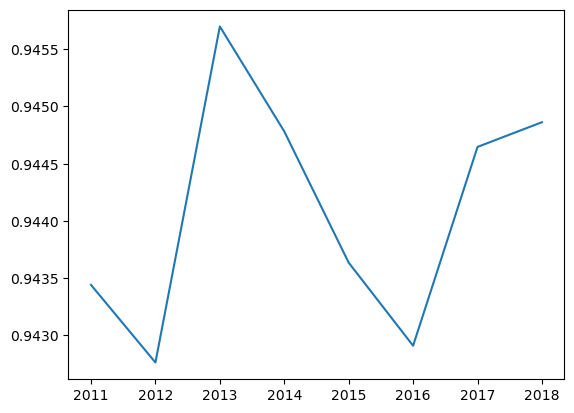

In [6]:
#Evolution du ratio d'accident non mortels au fil des ans
plt.plot(compte,ev_racci)   

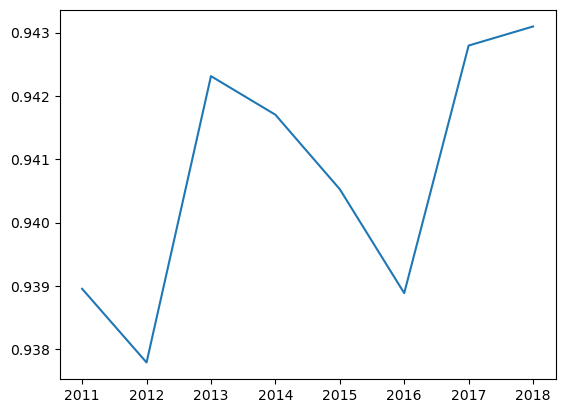

In [7]:
#Evolution du ratio des usqagers impliqués dans des accidents non mortels au fil des ans
plt.plot(compte,ev_rusag) 

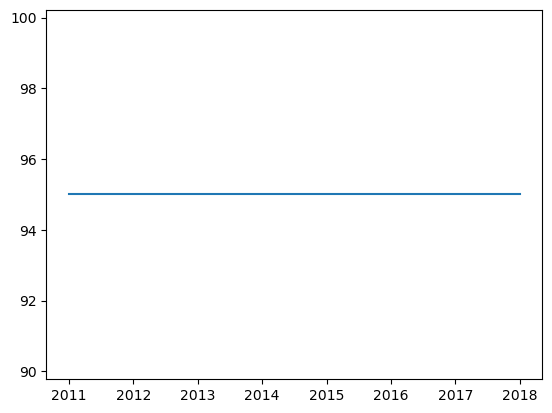

In [41]:
#Département le plus accidenté 
#95=Val d'Oise, Île-de-France
dep=[depplus[i][0] for i in range(n)] #affiche le numéro du département le plus accidenté pendant ces 8 ans
plt.plot(compte,dep)

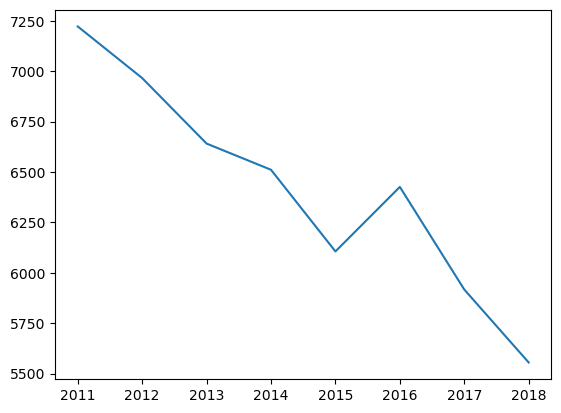

In [42]:
#Département le plus accidenté 
#95=Val d'Oise, Île-de-France
dep=[depplus[i][1] for i in range(n)] #affiche les accidents du 95
plt.plot(compte,dep)

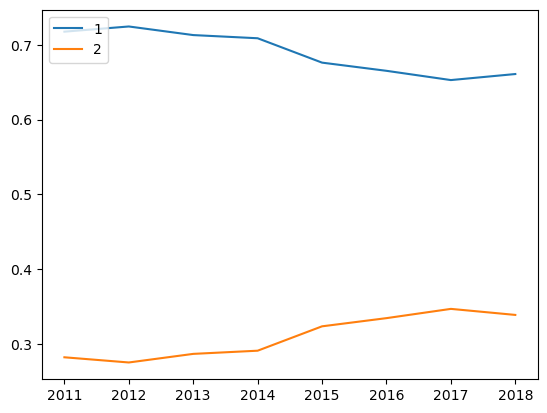

In [9]:
#Accidents en agglomération VS Hors agglomération
"""
1 – Hors agglomération
2 – En agglomération
"""
for i in range(0,2):
    affich=[agg[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i+1}")
plt.legend(loc="upper left")
plt.show()

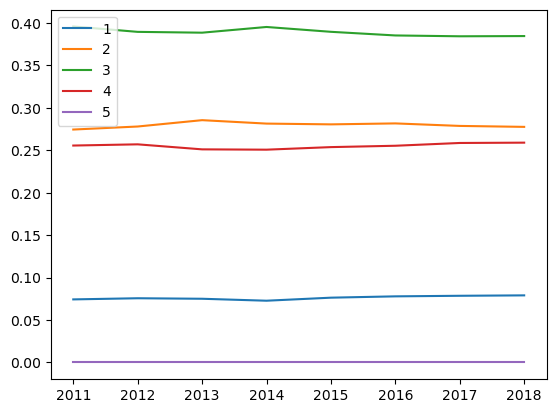

In [52]:
#Créneau horaire
"""
1 - 00-06h
2 - 06-12h
3 - 12-18h
4 - 18-00h
"""
for i in range(0,5):
    affich=[heu[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i+1}")
plt.legend(loc="upper left")
plt.show()

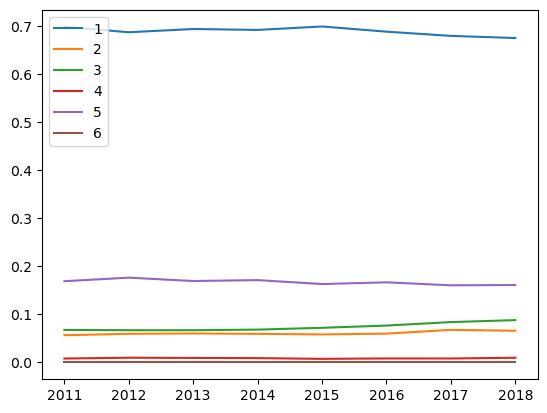

In [10]:
#Niveau de luminosité
"""
Lumière : conditions d’éclairage dans lesquelles l'accident s'est produit
1 – Plein jour
2 – Crépuscule ou aube
3 – Nuit sans éclairage public
4 - Nuit avec éclairage public non allumé
5 – Nuit avec éclairage public allumé
"""
for i in range(0,6):
    affich=[lum[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i+1}")
plt.legend(loc="upper left")
plt.show()

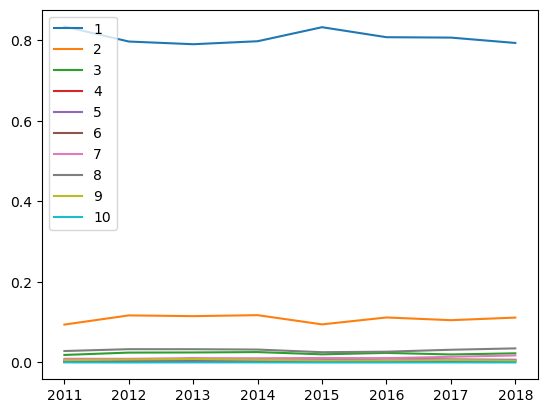

In [11]:
#Météo lors de l'accident
"""
1 – Normale
2 – Pluie légère
3 – Pluie forte
4 – Neige - grêle
5 – Brouillard - fumée
6 – Vent fort - tempête
7 – Temps éblouissant
8 – Temps couvert
9 – Autre
"""
for i in range(0,10):
    affich=[atm[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i+1}")
plt.legend(loc="upper left")
plt.show()

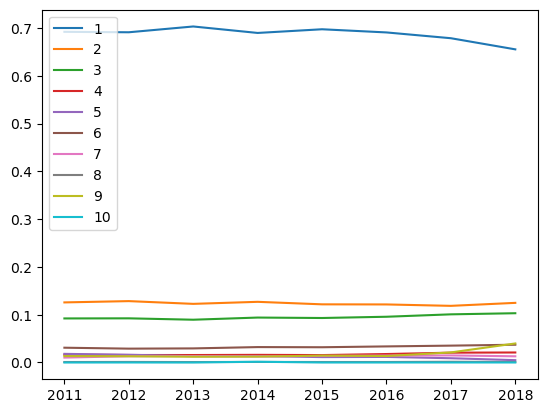

In [12]:
#Type d'intersection
"""
1 – Hors intersection
2 – Intersection en X
3 – Intersection en T
4 – Intersection en Y
5 - Intersection à plus de 4 branches
6 - Giratoire
7 - Place
8 – Passage à niveau
9 – Autre intersection
"""
for i in range(0,10):
    affich=[inter[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i+1}")
plt.legend(loc="upper left")
plt.show()

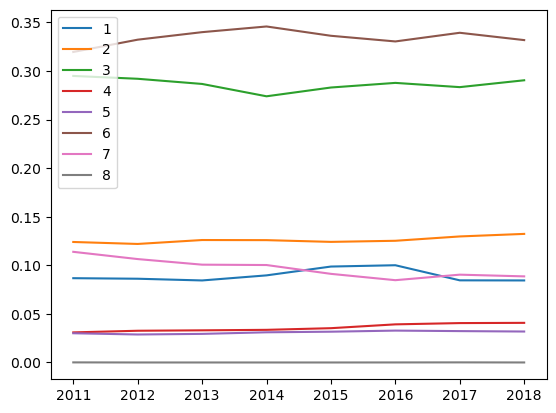

In [13]:
#Type de collision
"""
1 – Deux véhicules - frontale
2 – Deux véhicules – par l’arrière
3 – Deux véhicules – par le coté
4 – Trois véhicules et plus – en chaîne
5 – Trois véhicules et plus - collisions multiples
6 – Autre collision
7 – Sans collision
"""
for i in range(0,8):
    affich=[col[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i+1}")
plt.legend(loc="upper left")
plt.show()

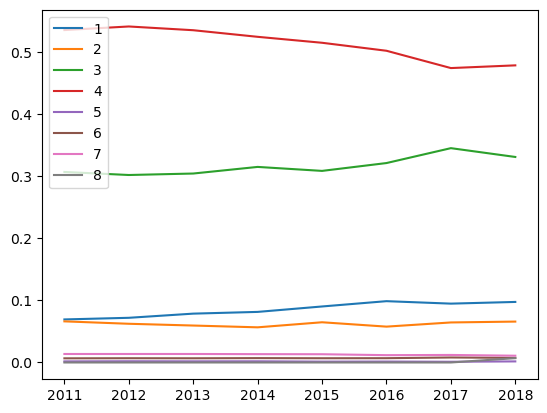

In [14]:
#Catégorie de route
"""
1 - Autoroute
2 - Route Nationale
3 - Route Départementale
4 - Voie Communale
5 - Hors réseau public
6 - Parc de stationnement ouvert à la circulation publique 
7 – autre
"""
for i in range(0,8):
    affich=[catr[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i+1}")
plt.legend(loc="upper left")
plt.show()

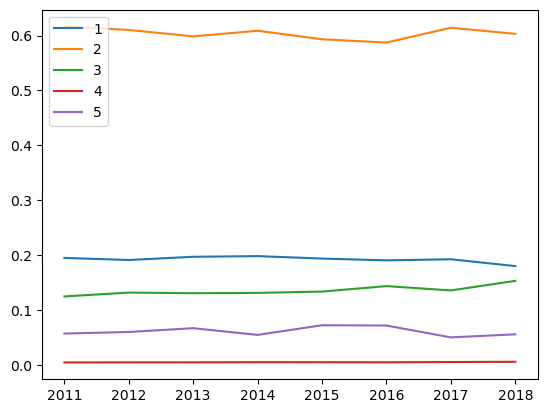

In [15]:
#Sens de circulation de la voie
"""
1 – A sens unique
2 – Bidirectionnelle
3 – A chaussées séparées
4 – Avec voies d’affectation variable
"""
for i in range(0,5):
    affich=[circ[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i+1}")
plt.legend(loc="upper left")
plt.show()

0.5602665147342766


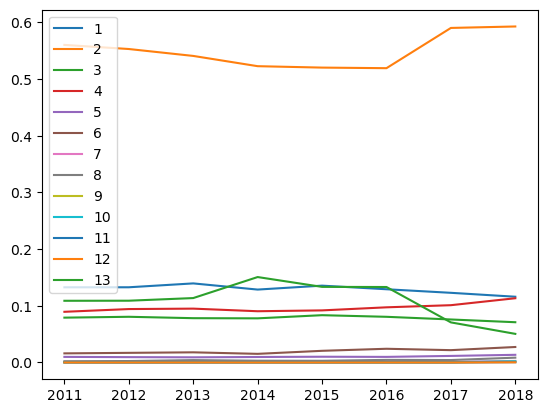

In [51]:
#Nombre total de voies de circulation (1,12)
for i in range(0,13):
    affich=[nbv[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i+1}")
print(nbv[0][1]) #2 Voies
plt.legend(loc="upper left")
plt.show()

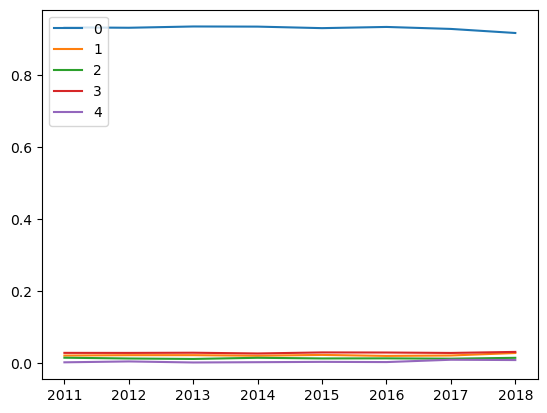

In [17]:
#Existence d'une voie réservée alentour
"""
0 - Aucune voie réservée
1 – Piste cyclable
2 – Banque cyclable
3 – Voie réservée"""
for i in range(0,5):
    affich=[vosp[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i}")
plt.legend(loc="upper left")
plt.show()

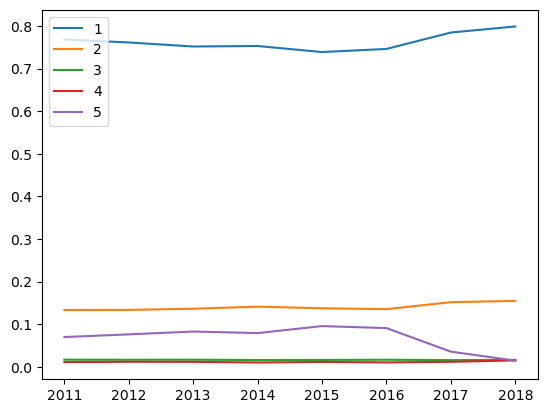

In [18]:
#Profil de la route (inclinaison)
"""
1 - Plat
2 - Pente
3 - Sommet de côte
4- Bas de côte
"""
for i in range(0,5):
    affich=[prof[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i+1}")
plt.legend(loc="upper left")
plt.show()

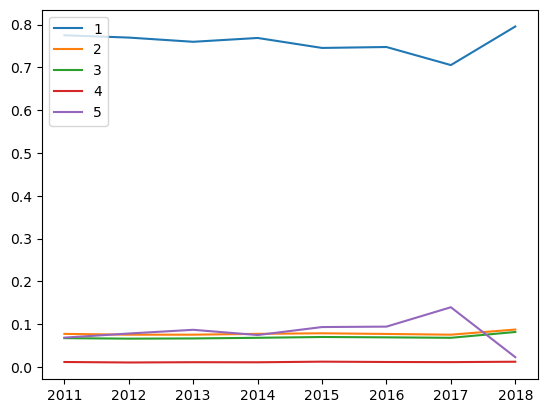

In [19]:
#Tracé de la route
"""
1 – Partie rectiligne
2 – En courbe à gauche
3 – En courbe à droite
4 – En « S »
"""
for i in range(0,5):
    affich=[plan[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i+1}")
plt.legend(loc="upper left")
plt.show()

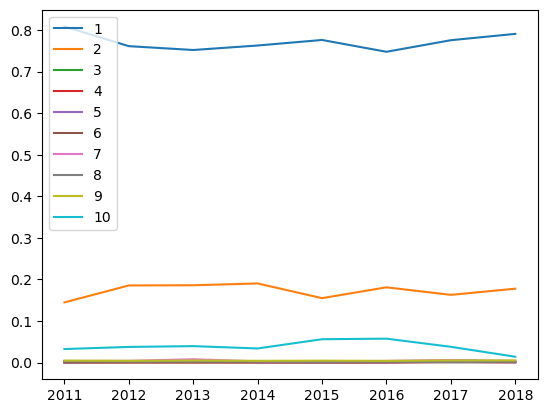

In [20]:
#Etat de la surface
"""
1 - normale
2 - mouillée
3 - flaques
4 - inondée
5 - enneigée
6 - boue
7 - verglacée
8 - corps gras - huile
9 - autre
"""
for i in range(0,10):
    affich=[surf[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i+1}")
plt.legend(loc="upper left")
plt.show()

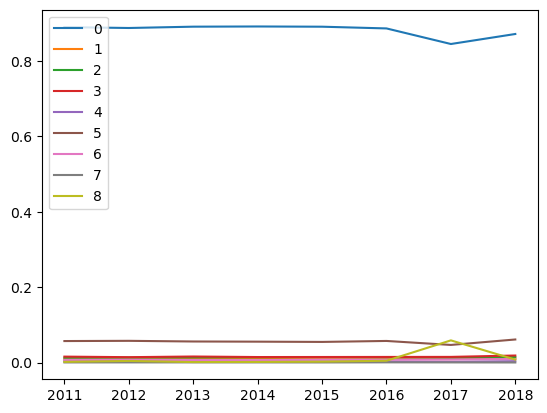

In [21]:
#Infrastructure alentour
"""
0 - Aucune infrastructure particulière
1 – Souterrain - tunnel
2 – Pont - autopont
3 – Bretelle d’échangeur ou de raccordement
4 - Voie ferrée
5 – Carrefour aménagé
6 – Zone piétonne
7 – Zone de péage
"""
for i in range(0,9):
    affich=[infra[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i}")
plt.legend(loc="upper left")
plt.show()

0.6080705009276438


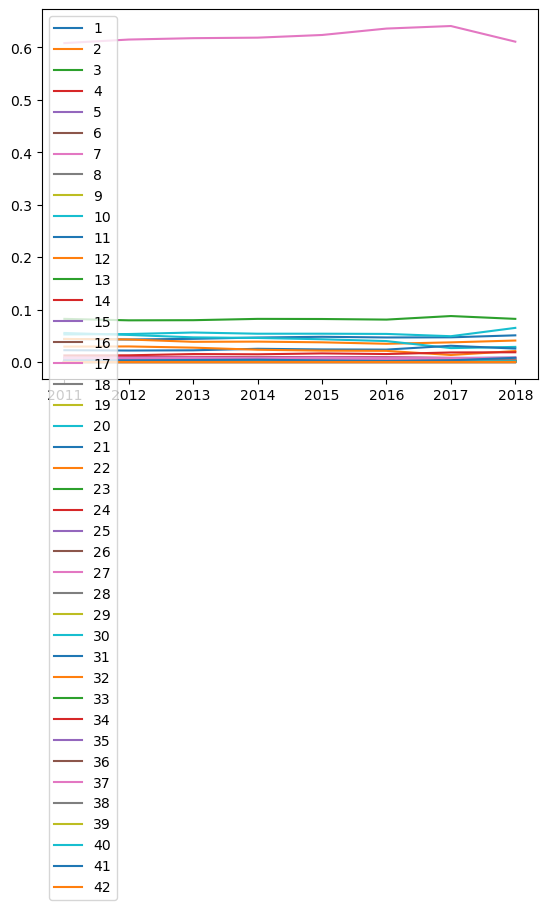

In [50]:
#Catégorie du véhicule
"""
01 - Bicyclette
02 - Cyclomoteur <50cm3
03 - Voiturette (Quadricycle à moteur carrossé) (anciennement "voiturette ou tricycle à moteur")
04 - Référence plus utilisée depuis 2006 (scooter immatriculé)
05 - Référence plus utilisée depuis 2006 (motocyclette)
06 - Référence plus utilisée depuis 2006 (side-car)
07 - VL seul
08 - Catégorie plus utilisée (VL + caravane)
09 - Catégorie plus utilisée (VL + remorque)
10 - VU seul 1,5T <= PTAC <= 3,5T avec ou sans remorque (anciennement VU seul 1,5T <= PTAC <=
3,5T)
11 - Référence plus utilisée depuis 2006 (VU (10) + caravane)
12 - Référence plus utilisée depuis 2006 (VU (10) + remorque)
13 - PL seul 3,5T <PTCA <= 7,5T
14 - PL seul > 7,5T
15 - PL > 3,5T + remorque
16 - Tracteur routier seul
17 - Tracteur routier + semi-remorque
18 - Référence plus utilisée depuis 2006 (transport en commun)
19 - Référence plus utilisée depuis 2006 (tramway)
20 - Engin spécial
21 - Tracteur agricole
30 - Scooter < 50 cm3
31 - Motocyclette > 50 cm3 et <= 125 cm3
32 - Scooter > 50 cm3 et <= 125 cm3
33 - Motocyclette > 125 cm3
34 - Scooter > 125 cm3
35 - Quad léger <= 50 cm3 (Quadricycle à moteur non carrossé)
36 - Quad lourd > 50 cm3 (Quadricycle à moteur non carrossé)
37 - Autobus
38 - Autocar
39 - Train
40 - Tramway
99 - Autre véhicule (dont piéton en roller ou en trottinette à partir de l’année 2018 requalifié en "engin de
déplacement personnel")
"""
print(catv[0][6]) #VL seul
for i in range(0,42):
    affich=[catv[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i+1}")
plt.legend(loc="upper left")
plt.show()

0.6741936449941601


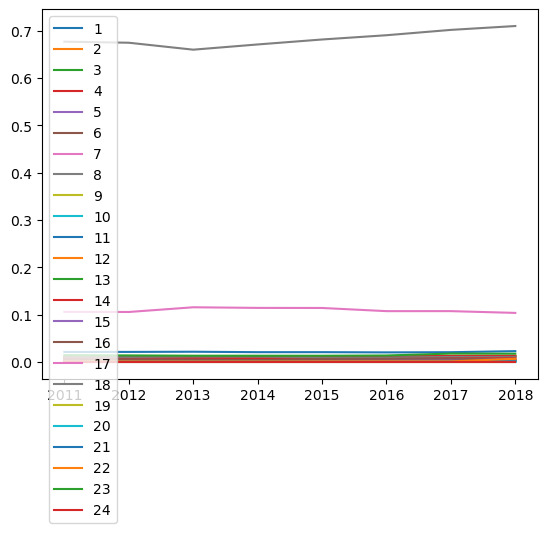

In [49]:
#Obstacle heurté
"""
1 – Véhicule en stationnement
2 – Arbre
3 – Glissière métallique
4 – Glissière béton
5 – Autre glissière
6 – Bâtiment, mur, pile de pont
7 – Support de signalisation verticale ou poste d’appel d’urgence
8 – Poteau
9 – Mobilier urbain
10 – Parapet
11 – Ilot, refuge, borne haute
12 – Bordure de trottoir
13 – Fossé, talus, paroi rocheuse
14 – Autre obstacle fixe sur chaussée
15 – Autre obstacle fixe sur trottoir ou accotement
16 – Sortie de chaussée sans obstacle
17 – Piéton
18 – Véhicule
19 – Véhicule sur rail
20 – Animal domestique
21 – Animal sauvage
22 – Autre
"""
print(obs[1][17])  #Véhicule est la plus grande source d'accidents
for i in range(0,24):
    affich=[obs[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i+1}")
plt.legend(loc="upper left")
plt.show()

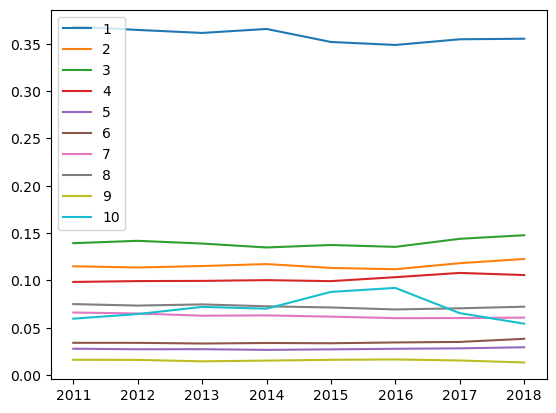

In [24]:
#Lieu du choc
"""
1 - Avant
2 – Avant droit
3 – Avant gauche
4 – Arrière
5 – Arrière droit
6 – Arrière gauche
7 – Côté droit
8 – Côté gauche
9 – Chocs multiples (tonneaux)
"""
for i in range(0,10):
    affich=[choc[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i+1}")
plt.legend(loc="upper left")
plt.show()

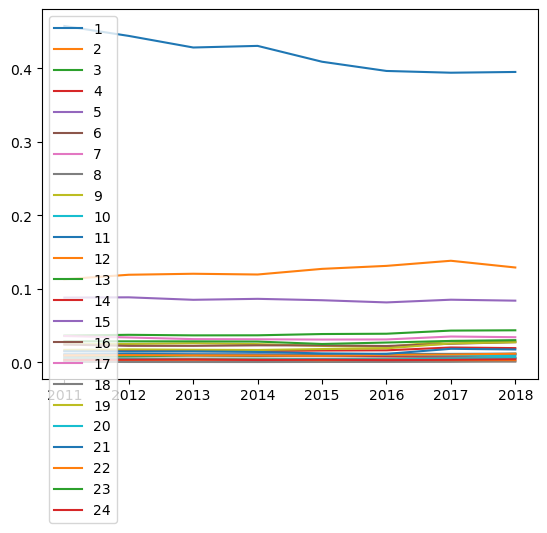

In [40]:
#Manoeuvre
"""
Manœuvre principale avant l’accident :
1 – Sans changement de direction
2 – Même sens, même file
3 – Entre 2 files
4 – En marche arrière
5 – A contresens
6 – En franchissant le terre-plein central
7 – Dans le couloir bus, dans le même sens
8 – Dans le couloir bus, dans le sens inverse
9 – En s’insérant
10 – En faisant demi-tour sur la chaussée
Changeant de file
11 – A gauche
12 – A droite
Déporté
13 – A gauche
14 – A droite
Tournant
15 – A gauche
16 – A droite
Dépassant
17 – A gauche
18 – A droite
Divers
19 – Traversant la chaussée
20 – Manœuvre de stationnement
21 – Manœuvre d’évitement
22 – Ouverture de porte
23 – Arrêté (hors stationnement)
24 – En stationnement (avec occupants)
"""
for i in range(0,24):
    affich=[manv[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i+1}")
plt.legend(loc="upper left")
plt.show()

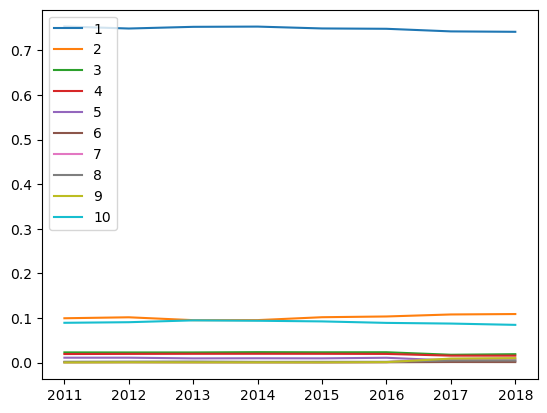

In [26]:
#Place de l'usager
"""
1-Conducteur
2-Passager devant côté fenêtre
3-Passager derrière droite
4-Passager derrière gauche
"""
for i in range(0,10):
    affich=[place[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i+1}")
plt.legend(loc="upper left")
plt.show()

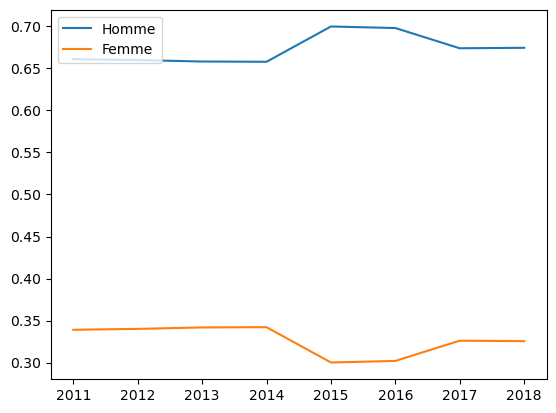

In [27]:
#Sexe
hom=[sexe[k][0] for k in range(n)]
fem=[sexe[k][1] for k in range(n)]
plt.plot(compte,hom,label="Homme")
plt.plot(compte,fem,label="Femme")
plt.legend(loc="upper left")
plt.show()

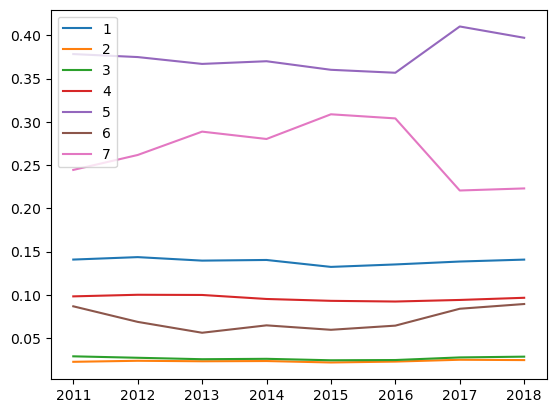

In [28]:
#Trajet
"""
1 – Domicile – travail
2 – Domicile – école
3 – Courses – achats
4 – Utilisation professionnelle
5 – Promenade – loisirs
6 – Autre
"""
for i in range(0,7):
    affich=[traj[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i+1}")
plt.legend(loc="upper left")
plt.show()

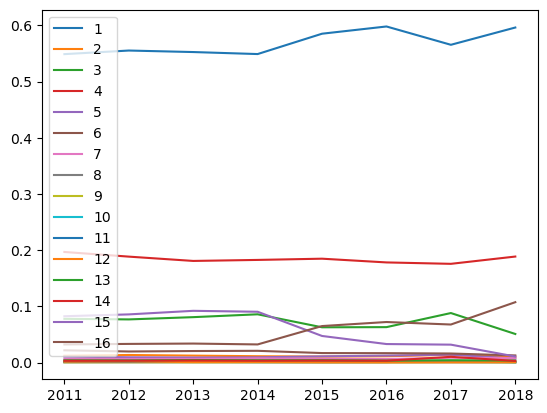

In [47]:
#Sécurité
"""
sur 2 caractères :
le premier concerne l’existence d’un Équipement de sécurité
1 – Ceinture
2 – Casque
3 – Dispositif enfants
4 – Equipement réfléchissant
9 – Autre
le second concerne l’utilisation de l’Équipement de sécurité
1 – Oui
2 – Non
3 – Non déterminable
D'où:
1 - Ceinture/Oui
2 - Ceinture/Non
3 - Ceinture/Non determinable
4 - Casque/Oui
5 - Casque/Non
6 - Casque/Non déterminable
7 - Dispositifs enfants/Oui
8 - Dispositifs enfants/Non
9 - Dispositifs enfants/Non déterminable
10 - Equipement réfléchissant/Oui
11 - Equipement réfléchissant/Non
12 - Equipement réfléchissant/Non déterminable
13 - Autre/Oui
14 - Autre/Non
15 - Autre/Non déterminable
"""
for i in range(0,16):
    affich=[secu[k][i] for k in range(n)]
    plt.plot(compte,affich,label=f"{i+1}")
plt.legend(loc="upper left")
plt.show()

In [93]:
#Individu ayant le plus de chances d'avoir un accident NON mortel:
aggnm='1' #"Hors agglomération" 
lumnm='1'   #"Plein jour" 
heunm= '3' #"12-18h" 
depplusnm='95' #"Val d'Oise" 
atmnm='1' #"Normale" 
internm='1' #"Hors intersection" 
colnm='6' #"Autre collision"
catrnm='4' #"Voie Communale" 
circnm='2' #"Bidirectionnelle" 
nbvnm='2' #"2 Voies" 
vospnm='0' #"Aucune voie réservée" 
profnm='1' #"Plat"
plannm='1' #"Partie rectiligne" 
surfnm='1' #"Normale"
infranm='0' #"Aucune infrastructure particulière" 
catvnm='7' #"Véhicule Léger seul"
obsnm='18' #"Véhicule"
chocnm='1' #"Avant"
manvnm= '01' #"Sans changement de direction"
placenm='1' #"Conducteur" 
sexenm='1' #"Homme" 
trajnm='5'  #"Promenade – loisirs" 
secunm='11' #"Ceinture/Oui" 

In [119]:
"""aggf=[]
lumf=[]
heuf=[]
atmf=[]
interf=[]
colf=[]
catrf=[]
circf=[]"""
nbvf=[]
"""vospf=[]
proff=[]
planf=[]
surff=[]
infraf=[]"""
catvf=[]
obsf=[]
#chocf=[]
manvf=[]
#placef=[]
sexef=[]
#trajf=[]
#secuf=[]

In [120]:
rddtc.filter(lambda x : x['agg']=='0').count()

0

In [121]:
#Vérification:
for i in compte:
    #Année étudiée
    print(f"Année {i}")
    
    #On récupère en premier lieu les accident ne comportant aucun mort, on va devoir filtrer les usagers
    usag = spark.read.load(f"usagers_{i}.csv",format="csv",header=True)
    
    #Conversion du DataFrame en RDD pour utiliser filter
    rddu=usag.rdd
    
    #Regroupe les accidents comportant un mort, spécifiquement leur Num_Acc, numéro d'accident
    rddmort=rddu.filter(lambda x: x['grav']=='2') 
    lmort=rddmort.collect()
    L=[lmort[i][0] for i in range(len(lmort))]

    #On récupère les lieux , les végicules et les caractéristiques des accidents de l'année i 
    lieux=spark.read.load(f"lieux_{i}.csv",format="csv",header=True)
    vehic=spark.read.load(f"vehicules_{i}.csv",format="csv",header=True)
    carac=spark.read.load(f"caracteristiques_{i}.csv",format="csv",header=True)
    """
    lieux.show(n=5)
    vehic.show(n=5)
    carac.show(n=5)
    """

    #Conversion en rdd
    rddl=lieux.rdd
    rddv=vehic.rdd
    rddc=carac.rdd
    
    #On filtre ces nouveaux rdd en excluant les accidents mortels
    rddtu=rddu.filter(lambda x: x['Num_Acc'] in L)
    rddtl=rddl.filter(lambda x: x['Num_Acc'] in L)
    rddtv=rddv.filter(lambda x: x['Num_Acc'] in L)
    rddtc=rddc.filter(lambda x: x['Num_Acc'] in L)
    
    
    nombr_usagers_filt=rddtu.count()
    nombr_acci_filt=rddtc.count()
    nombr_vehic_filt=rddtv.count()
    """
    aggf.append(rddtc.filter(lambda x : x['agg']==aggnm).count()/nombr_acci_filt)
    lumf.append(rddtc.filter(lambda x : x['lum']==lumnm).count()/nombr_acci_filt)
    heuf.append(rddtc.filter(lambda x : x['agg']==aggnm).count()/nombr_acci_filt)
    atmf.append(rddtc.filter(lambda x : int(x['hrmn'])<=1800 and int(x['hrmn'])>1200).count()/nombr_acci_filt)
    interf.append(rddtc.filter(lambda x : x['int']==internm).count()/nombr_acci_filt)
    colf.append(rddtc.filter(lambda x : x['col']==colnm).count()/nombr_acci_filt)
    catrf.append(rddtl.filter(lambda x : x['catr']==catrnm).count()/nombr_acci_filt)
    circf.append(rddtl.filter(lambda x : x['circ']==circnm).count()/nombr_acci_filt)"""
    nbvf.append(rddtl.filter(lambda x : x['nbv']==nbvnm).count()/nombr_acci_filt)
    """vospf.append(rddtl.filter(lambda x : x['vosp']==vospnm).count()/nombr_acci_filt)
    proff.append(rddtl.filter(lambda x : x['prof']==profnm).count()/nombr_acci_filt)
    planf.append(rddtl.filter(lambda x : x['plan']==plannm).count()/nombr_acci_filt)
    surff.append(rddtl.filter(lambda x : x['surf']==surfnm).count()/nombr_acci_filt)
    infraf.append(rddtl.filter(lambda x : x['infra']==infranm).count()/nombr_acci_filt)"""
    catvf.append(rddtv.filter(lambda x : x['catv']==catvnm).count()/nombr_vehic_filt)
    obsf.append(rddtv.filter(lambda x : x['obs']==obsnm).count()/nombr_vehic_filt)
    #chocf.append(rddtv.filter(lambda x : x['choc']==chocnm).count()/nombr_vehic_filt)
    manvf.append(rddtv.filter(lambda x : x['manv']==manvnm).count()/nombr_vehic_filt)
    #placef.append(rddtu.filter(lambda x : x['place']==placenm).count()/nombr_usagers_filt)
    sexef.append(rddtu.filter(lambda x : x['sexe']==sexenm).count()/nombr_usagers_filt)
    #trajf.append(rddtu.filter(lambda x : x['trajet']==trajnm).count()/nombr_usagers_filt)
    #secuf.append(rddtu.filter(lambda x : x['secu']==secunm).count()/nombr_usagers_filt)
    
    

Année 2011


Année 2012


Année 2013


Année 2014


Année 2015


Année 2016


Année 2017


Année 2018


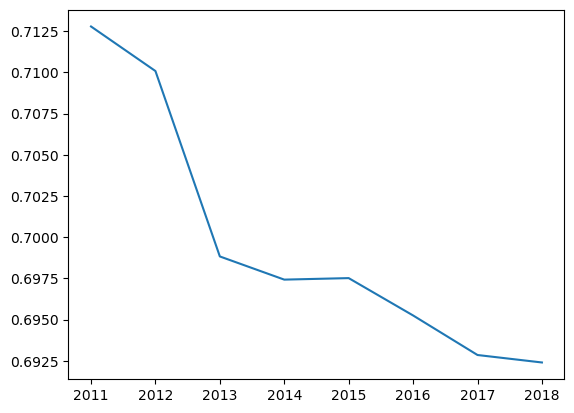

In [97]:
plt.plot(compte,aggf)

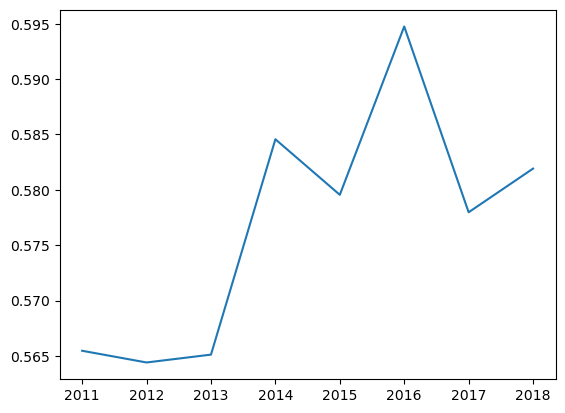

In [98]:
plt.plot(compte,lumf)

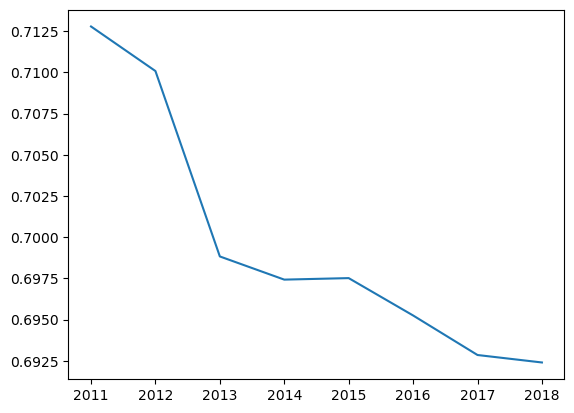

In [99]:
plt.plot(compte,heuf)

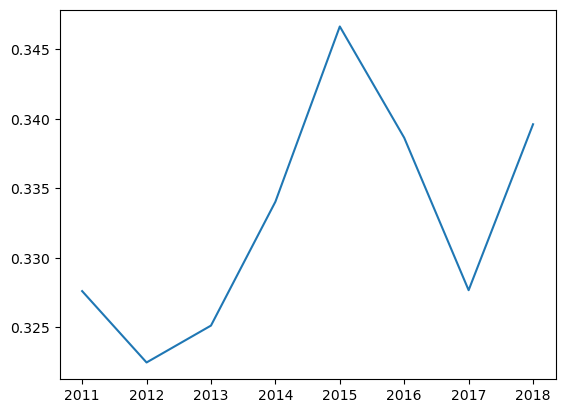

In [100]:
plt.plot(compte,atmf)

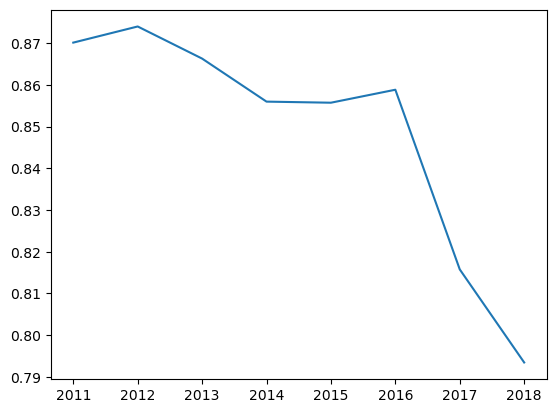

In [101]:
plt.plot(compte,interf)

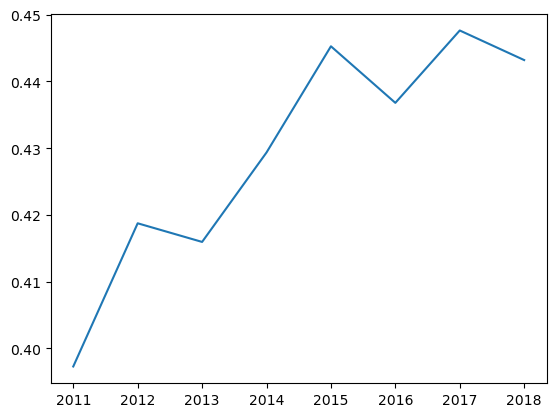

In [102]:
plt.plot(compte,colf)

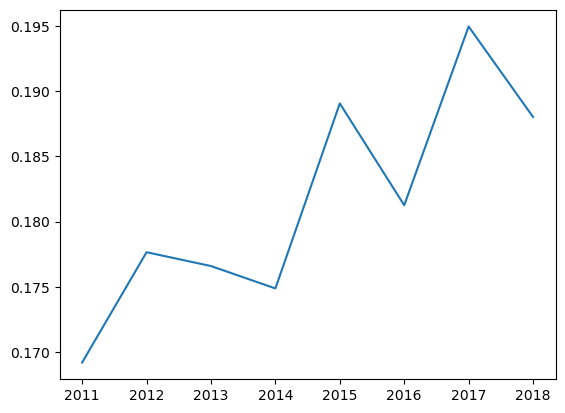

In [103]:
plt.plot(compte,catrf)

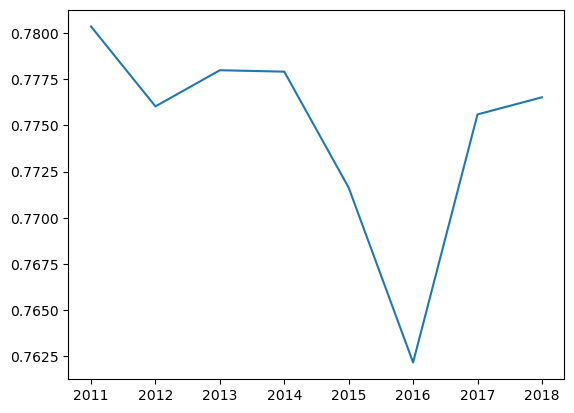

In [104]:
plt.plot(compte,circf)

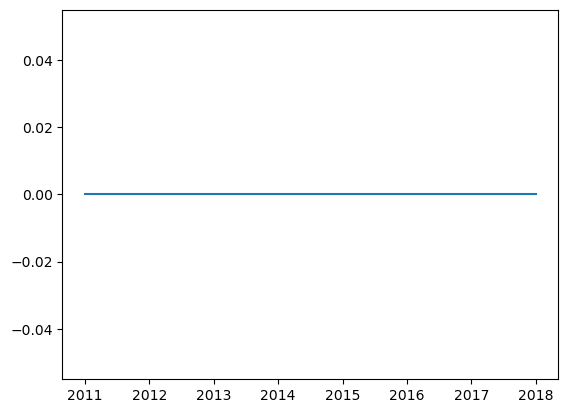

In [122]:
plt.plot(compte,nbvf)

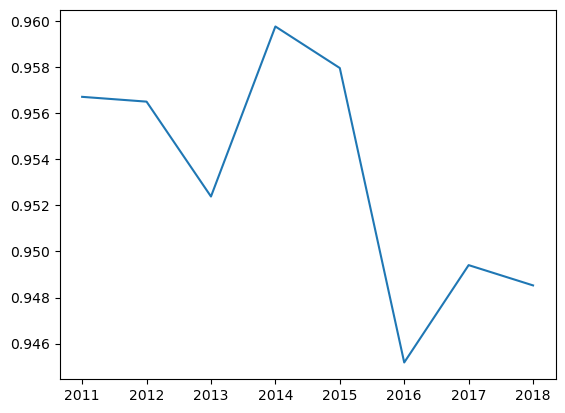

In [106]:
plt.plot(compte,vospf)

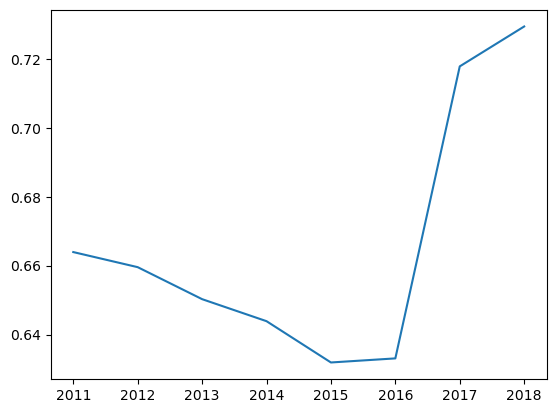

In [107]:
plt.plot(compte,proff)

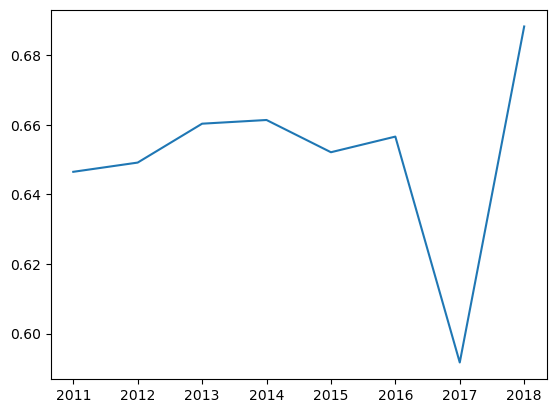

In [108]:
plt.plot(compte,planf)

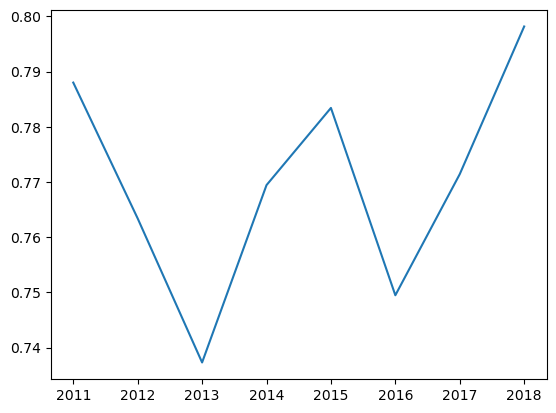

In [109]:
plt.plot(compte,surff)

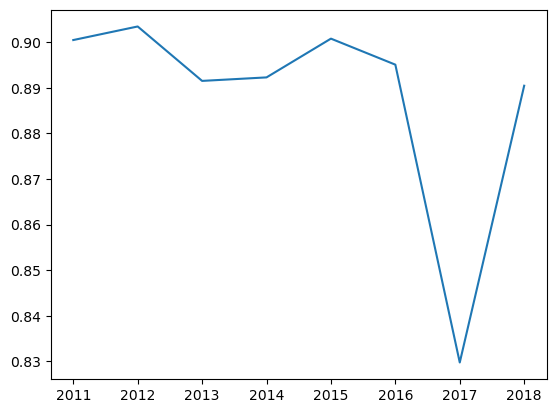

In [110]:
plt.plot(compte,infraf)

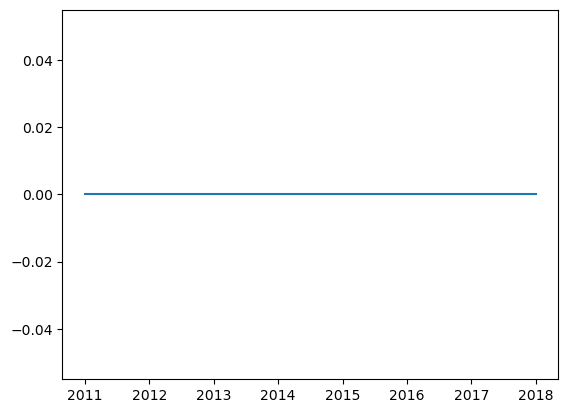

In [123]:
plt.plot(compte,catvf)

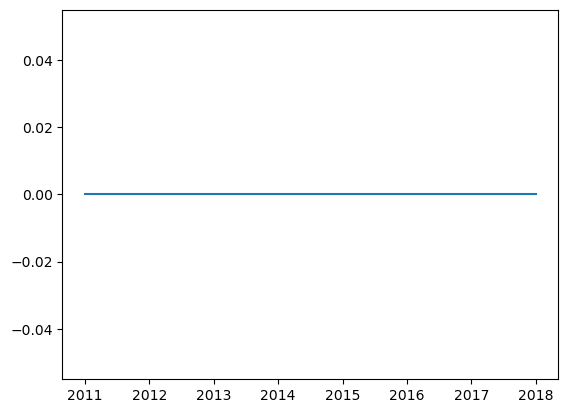

In [124]:
plt.plot(compte,obsf)

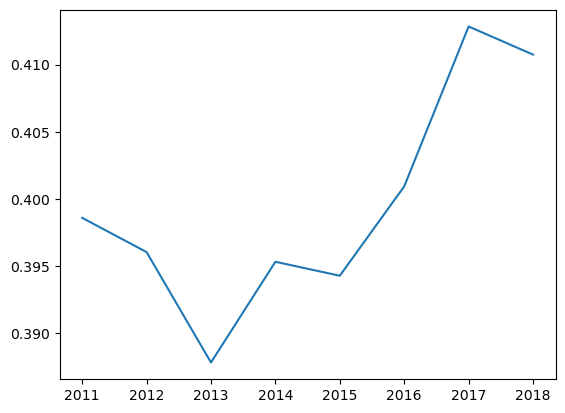

In [113]:
plt.plot(compte,chocf)

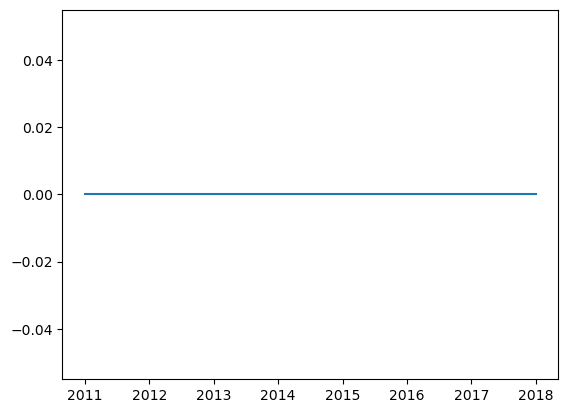

In [126]:
plt.plot(compte,manvf)

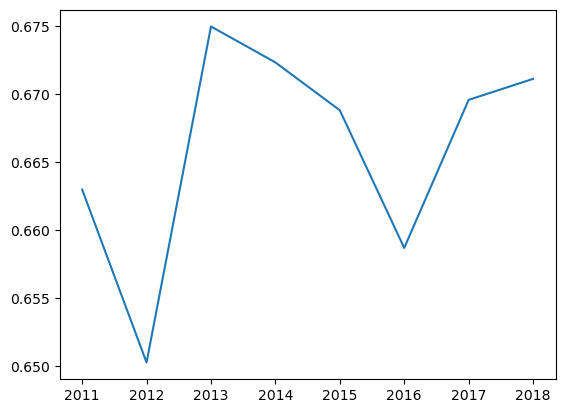

In [127]:
plt.plot(compte,placef)

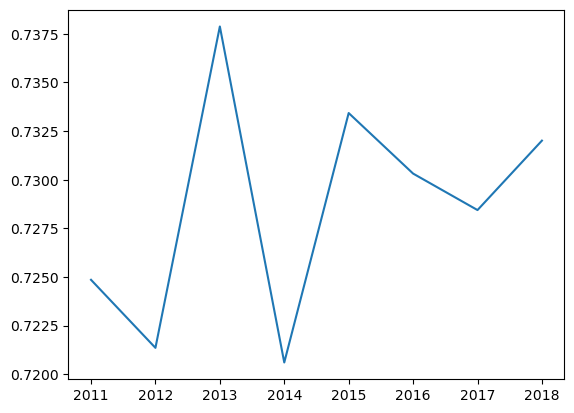

In [128]:
plt.plot(compte,sexef)

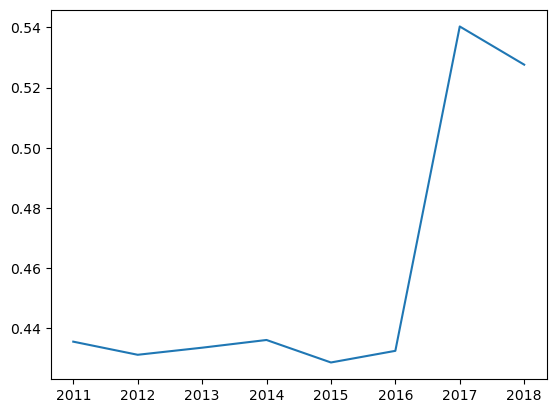

In [129]:
plt.plot(compte,trajf)

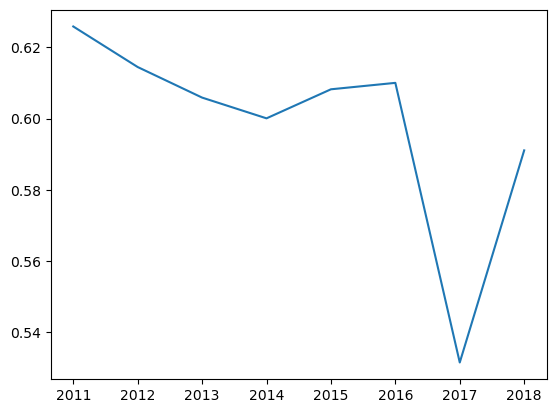

In [118]:
plt.plot(compte,secuf)